In [1]:
import pandas as pd
import numpy as np
from scipy.linalg import block_diag
import matplotlib.pyplot as plt
import statsmodels.tsa.stattools as ts 
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# Data Cleaning - SPY & SSO

## Remove Before-and-After-Market-Hour Data

In [40]:
def get_df(ticker):
    file1='%s_20190101_.csv'%str(ticker)
    df=pd.read_csv(file1, index_col=0)
    df.columns = ['time', 'bs', 'bid', 'as', 'ask']
    df = df.dropna()
#     df['time']=df['time'].astype(float)
    df['bid']=df['bid'].astype(float)
    df['ask']=df['ask'].astype(float)
    df['bs']=df['bs'].astype(float)
    df['as']=df['as'].astype(float)
    df['mid']=(df['bid'].astype(float)+df['ask'].astype(float))/2
    df['imb']=df['bs'].astype(float)/(df['bs'].astype(float)+df['as'].astype(float))
    df['wmid']=df['ask'].astype(float)*df['imb']+df['bid'].astype(float)*(1-df['imb'])
    
    # New Changes Added
    df = df[(df[['bs','bid','ask','as','mid','imb','wmid']] != 0).all(axis=1)]  # Remove tick data with bid/ask size equal to 0
    df = df.reset_index(drop=True)                                              # Reset index 
    df['time'] = pd.to_datetime(df['time'])                                     # Change time to datetime type         
    df.set_index('time', inplace=True)                                          # Set index to use between_time func
    df = df.between_time('09:30', '16:00')                                      # Only choose normal market data
    df = df.reset_index()                                                       # Reset index 
    
    # Fill Missing Data with Nearest
    df['time'] = pd.to_datetime(df['time'])                                     # Change time to datetime type
    df.drop_duplicates(subset ="time", keep = 'first', inplace = True)          # Set first row of any second as a representative
    df = df.set_index('time')
    df = df.asfreq('S')                                                         # Fill missing second with NAN
    df = df.interpolate(method='nearest')                                            # Replace NAN with nearest value
    df = df.between_time('09:30', '16:00')
    df = df.reset_index() 
    
    return df

## Plot Normal-Market Data

In [3]:
data=get_df('SPY')[0:10000]

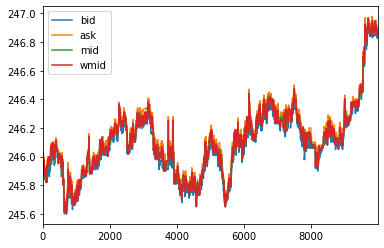

In [4]:
data[['bid','ask','mid','wmid']].plot()

In [5]:
data.head()

,time,bs,bid,as,ask,mid,imb,wmid
0,2019-01-02 09:30:00+00:00,2500.0,245.88,1000.0,246.00,245.94,0.714286,245.965714
1,2019-01-02 09:30:01+00:00,2500.0,245.88,500.0,245.98,245.93,0.833333,245.963333
2,2019-01-02 09:30:02+00:00,2500.0,245.88,500.0,245.98,245.93,0.833333,245.963333
3,2019-01-02 09:30:03+00:00,2500.0,245.88,500.0,245.98,245.93,0.833333,245.963333
4,2019-01-02 09:30:04+00:00,500.0,245.90,500.0,246.00,245.95,0.500000,245.950000


# Compute Microprice

In [33]:
def prep_data_sym(T,n_imb,dt,n_spread):
    spread=T.ask-T.bid
    ticksize=np.round(min(spread.loc[spread>0])*100)/100
    T.spread=T.ask-T.bid
    # adds the spread and mid prices
    T['spread']=np.round((T['ask']-T['bid'])/ticksize)*ticksize
    T['mid']=(T['bid']+T['ask'])/2
    #filter out spreads >= n_spread
    T = T.loc[(T.spread <= n_spread*ticksize) & (T.spread>0)]
    T['imb']=T['bs']/(T['bs']+T['as'])
    #discretize imbalance into percentiles
    T['imb_bucket'] = pd.qcut(T['imb'].rank(method='first'), n_imb, labels=False) 
    T['next_mid']=T['mid'].shift(-dt)
    #step ahead state variables
    T['next_spread']=T['spread'].shift(-dt)
    T['next_time']=T['time'].shift(-dt)
    T['next_imb_bucket']=T['imb_bucket'].shift(-dt)
    # step ahead change in price
    T['dM']=np.round((T['next_mid']-T['mid'])/ticksize*2)*ticksize/2
    T = T.loc[(T.dM <= ticksize*1.1) & (T.dM>=-ticksize*1.1)]
    # symetrize data
    T2 = T.copy(deep=True)
    T2['imb_bucket']=n_imb-1-T2['imb_bucket']
    T2['next_imb_bucket']=n_imb-1-T2['next_imb_bucket']
    T2['dM']=-T2['dM']
    T2['mid']=-T2['mid']
    T3=pd.concat([T,T2])
    T3.index = pd.RangeIndex(len(T3.index)) 
    return T3,ticksize

def estimate(T):
    no_move=T[T['dM']==0]
    no_move_counts=no_move.pivot_table(index=[ 'next_imb_bucket'], 
                     columns=['spread', 'imb_bucket'], 
                     values='time',
                     fill_value=0, 
                     aggfunc='count').unstack()
    Q_counts=np.resize(np.array(no_move_counts[0:(n_imb*n_imb)]),(n_imb,n_imb))
    # loop over all spreads and add block matrices
    for i in range(1,n_spread):
        Qi=np.resize(np.array(no_move_counts[(i*n_imb*n_imb):(i+1)*(n_imb*n_imb)]),(n_imb,n_imb))
        Q_counts=block_diag(Q_counts,Qi)
    #print Q_counts
    move_counts=T[(T['dM']!=0)].pivot_table(index=['dM'], 
                         columns=['spread', 'imb_bucket'], 
                         values='time',
                         fill_value=0, 
                         aggfunc='count').unstack()

    R_counts=np.resize(np.array(move_counts),(n_imb*n_spread,4))
    T1=np.concatenate((Q_counts,R_counts),axis=1).astype(float)
    for i in range(0,n_imb*n_spread):
        T1[i]=T1[i]/T1[i].sum()
    Q=T1[:,0:(n_imb*n_spread)]
    R1=T1[:,(n_imb*n_spread):]

    K=np.array([-0.01, -0.005, 0.005, 0.01])
    move_counts=T[(T['dM']!=0)].pivot_table(index=['spread','imb_bucket'], 
                     columns=['next_spread', 'next_imb_bucket'], 
                     values='time',
                     fill_value=0, 
                     aggfunc='count') #.unstack()

    R2_counts=np.resize(np.array(move_counts),(n_imb*n_spread,n_imb*n_spread))
    T2=np.concatenate((Q_counts,R2_counts),axis=1).astype(float)

    for i in range(0,n_imb*n_spread):
        T2[i]=T2[i]/T2[i].sum()
    R2=T2[:,(n_imb*n_spread):]
    Q2=T2[:,0:(n_imb*n_spread)]
    G1=np.dot(np.dot(np.linalg.inv(np.eye(n_imb*n_spread)-Q),R1),K)
    B=np.dot(np.linalg.inv(np.eye(n_imb*n_spread)-Q),R2)
    
    return G1,B,Q,Q2,R1,R2,K

def plot_Gstar(ticker,G1,B,T):
    G2=np.dot(B,G1)+G1
    G3=G2+np.dot(np.dot(B,B),G1)
    G4=G3+np.dot(np.dot(np.dot(B,B),B),G1)
    G5=G4+np.dot(np.dot(np.dot(np.dot(B,B),B),B),G1)
    G6=G5+np.dot(np.dot(np.dot(np.dot(np.dot(B,B),B),B),B),G1)
    plt.plot(imb,np.linspace(-0.005,0.005,n_imb)*0,label='Mid adj',marker='o')
    plt.plot(imb,np.linspace(-0.005,0.005,n_imb),label='Weighted mid adj',marker='o')
    for i in range(0,n_spread):
        plt.plot(imb,G6[(0+i*n_imb):(n_imb+i*n_imb)],label="spread = "+str(i+1)+" tick adj",marker='o')
    plt.ylim(-0.005,0.005)
    plt.legend(loc='upper left')
    plt.title(ticker+' adjustments')
    plt.xlabel('Imbalance')
    return G6

## Microprice - SPY

In [34]:
n_imb=4                                            # Quartiles [0, .25, .5, .75, 1.] 
n_spread=4                                         # Filter out spreads > n_spread
dt=1
SPY=get_df('SPY') 
ticker='SPY'
T,ticksize=prep_data_sym(SPY,n_imb,dt,n_spread)
imb=np.linspace(0,1,n_imb)
G1,B,Q,Q2,R1,R2,K=estimate(T)

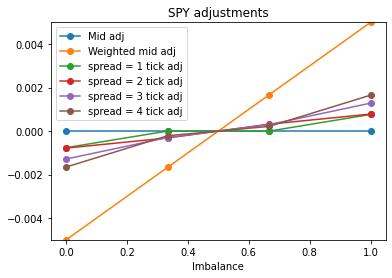

In [35]:
G6=plot_Gstar(ticker,G1,B,T)

Text(0.5, 0, 'Imbalance')

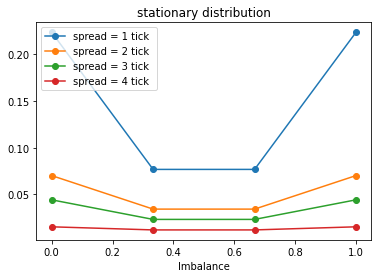

In [36]:
W=np.linalg.matrix_power(B,100)
for i in range(0,n_spread):
    plt.plot(imb,W[0][(0+i*n_imb):(n_imb+i*n_imb)],label="spread = "+str(i+1)+" tick ",marker='o')
    
plt.legend(loc='upper left')
plt.title('stationary distribution')
plt.xlabel('Imbalance')

## Microprice - SSO

In [37]:
n_imb=4
n_spread=4
dt=1
SSO=get_df('SSO') 
ticker='SSO'
T,ticksize=prep_data_sym(SSO,n_imb,dt,n_spread)
imb=np.linspace(0,1,n_imb)
G1,B,Q,Q2,R1,R2,K=estimate(T)

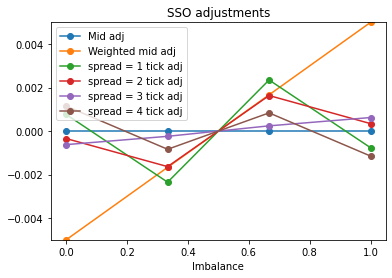

In [38]:
G6=plot_Gstar(ticker,G1,B,T)

Text(0.5, 0, 'Imbalance')

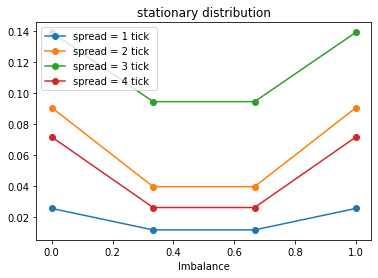

In [39]:
W=np.linalg.matrix_power(B,100)
for i in range(0,n_spread):
    plt.plot(imb,W[0][(0+i*n_imb):(n_imb+i*n_imb)],label="spread = "+str(i+1)+" tick ",marker='o')
    
plt.legend(loc='upper left')
plt.title('stationary distribution')
plt.xlabel('Imbalance')

# Cointegration 

In [41]:
SPY=get_df('SPY')
SPY['time'] = pd.to_datetime(SPY['time'])   # Change time to datetime type
SPY.drop_duplicates(subset ="time", keep = 'first', inplace = True) # Set first row of any second as a representative
SPY = SPY[['time', 'mid']]
SPY.columns = ['time', 'mid_SPY']

SSO=get_df('SSO')
SSO['time'] = pd.to_datetime(SSO['time'])   # Change time to datetime type
SSO.drop_duplicates(subset ="time", keep = 'first', inplace = True) # Set first row of any second as a representative
SSO = SSO[['time', 'mid']]
SSO.columns = ['time', 'mid_SSO']

df = pd.concat([SPY.set_index('time'),SSO.set_index('time')], axis=1, join='inner')
df.head()


,mid_SPY,mid_SSO
time,,
2019-01-02 09:30:00+00:00,245.94,89.735
2019-01-02 09:30:01+00:00,245.93,89.720
2019-01-02 09:30:02+00:00,245.93,89.730
2019-01-02 09:30:03+00:00,245.93,89.730
2019-01-02 09:30:04+00:00,245.95,89.745


## Straightforward Plotting 

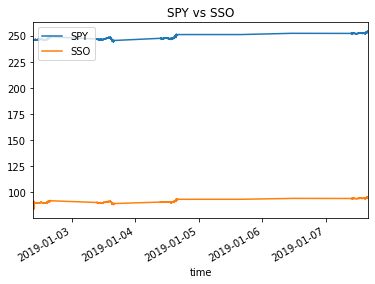

In [42]:
df.mid_SPY.plot(label="SPY")
df.mid_SSO.plot(label="SSO")
plt.legend(loc='upper left')
plt.title('SPY vs SSO')
plt.show()

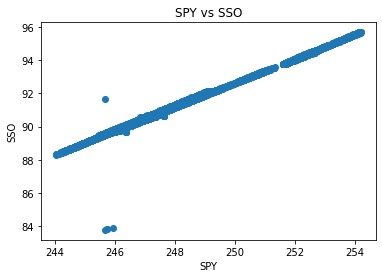

In [43]:
plt.scatter(df.mid_SPY, df.mid_SSO)
plt.title('SPY vs SSO')
plt.xlabel('SPY')
plt.ylabel('SSO')
plt.show()

## ADF Cointegration Test

In [44]:
# hedge ratio
model = sm.OLS(df.mid_SPY, df.mid_SSO)
model = model.fit() 
print('Hedge ratio between SPY and SSO is', model.params[0])

Hedge ratio between SPY and SSO is 2.7042484015761428


In [45]:
model.params

mid_SSO    2.704248
dtype: float64

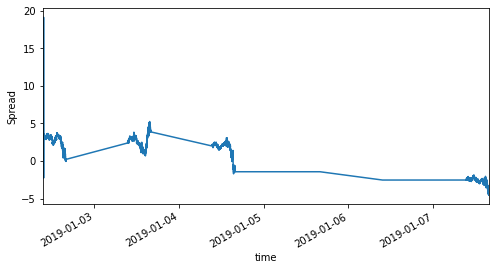

In [46]:
df['spread'] = df.mid_SPY - model.params[0] * df.mid_SSO
df.spread.plot(figsize=(8,4))
plt.ylabel("Spread")
plt.show()

In [47]:
df

,mid_SPY,mid_SSO,spread
time,,,
2019-01-02 09:30:00+00:00,245.940,89.735,3.274270
2019-01-02 09:30:01+00:00,245.930,89.720,3.304833
2019-01-02 09:30:02+00:00,245.930,89.730,3.277791
2019-01-02 09:30:03+00:00,245.930,89.730,3.277791
2019-01-02 09:30:04+00:00,245.950,89.745,3.257227
...,...,...,...
2019-01-07 15:59:56+00:00,253.915,95.485,-4.300159
2019-01-07 15:59:57+00:00,253.915,95.485,-4.300159
2019-01-07 15:59:58+00:00,253.915,95.485,-4.300159


In [48]:
adf = adfuller(df.spread, maxlag = 1)
adf[0]

-5.722378446027551

In [49]:
adf[4]

{'1%': -3.430396575735442,
 '5%': -2.8615605858106457,
 '10%': -2.566780957095286}

Conclusion: Since -4.59 < -3.43, Portfolio is Stationarity and SPY & SSO is cointegrated with more than 99% certainty.